/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]



=== Part A (Convergence to α⁻¹): top candidates by median relative error (TRAIN) ===
     seed        encoding   gate1   gate2  tri_k  med_rel_err_train  med_rel_err_test  train_bandwidth95  train_sign_change_rate  train_spectral_peak_ratio  test_bandwidth95  test_sign_change_rate  test_spectral_peak_ratio
        F binary_fraction x/(1-x)    comp      5           0.048277          0.048277                0.0                     0.0               3.037417e-01               0.0                    0.0              0.000000e+00
 R_over_F binary_fraction     inv    comp      5           0.052261          0.052261                0.0                     0.0               4.118669e-02               0.0                    0.0              2.616345e-18
 R_over_F binary_fraction (1-x)/x    comp      4           0.058161          0.058161                0.0                     0.0               1.164225e-17               0.0                    0.0              0.000000e+00
 R_over_F   decimal_bi

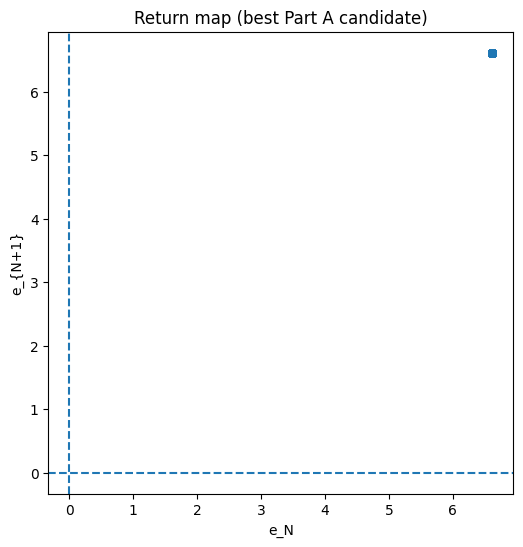

In [1]:
# @title Binary Heartbeat → Triadic Escalation → Fission/Fusion → Coupling: Two-Part Test
# @markdown **Seeds:** Fibonacci word (primary), Rabbit & Thue–Morse (controls)
# @markdown **Encodings:** decimal bigit "0.bits" and binary fraction Σ b_k 2^{-k}
# @markdown **Gates (depth=2):** id, 1/x, 1−x, x/(1−x), (1−x)/x
# @markdown **Triadic membrane:** × 3^k, k ∈ {-6,…,6}
# @markdown **Targets:** α⁻¹=137.035999 (plus π, φ, √2, e, γ, Catalan G, ζ(3))
# @markdown **Outputs:** CSVs + concise console summaries (train & holdout)

import math, itertools, warnings, statistics
import numpy as np
import pandas as pd
from decimal import Decimal, getcontext
import matplotlib.pyplot as plt

# ---------------- Parameters (edit if you like) ----------------
N_min, N_max, N_step = 50, 400, 1               # dense sweep to avoid plateaus
lengths = list(range(N_min, N_max+1, N_step))
holdout_boundary = int(N_min + 0.7*(N_max-N_min))  # 70/30 split by N
tri_k_vals = list(range(-6, 7))                   # 3^k membrane

# Gate depth (keep small for tractability & pre-declaration)
GATE_DEPTH = 2

# Decimal precision: safe margin for 400+ bits
getcontext().prec = N_max + 80

# Constants (Decimal where needed for high precision)
alpha_inv = Decimal("137.035999")
alpha     = Decimal(1) / alpha_inv
pi        = Decimal(str(math.pi))
phi       = Decimal((1 + 5**0.5) / 2)
sqrt2     = Decimal(str(math.sqrt(2)))
econst    = Decimal(str(math.e))
gamma     = Decimal("0.57721566490153286060")
CatalanG  = Decimal("0.91596559417721901505")
zeta3     = Decimal("1.20205690315959428540")

TARGETS = {
    "alpha_inv": alpha_inv,
    "pi": pi, "phi": phi, "sqrt2": sqrt2,
    "e": econst, "gamma": gamma, "CatalanG": CatalanG, "zeta3": zeta3,
}

# Coupling transforms (fixed, pre-declared)
def frac_part(x: float) -> float:
    return x - math.floor(x)

TRANSFORMS = {
    "s":        lambda s: s,
    "1/s":      lambda s: (np.inf if s==0 else 1.0/s),
    "s/alpha_inv": lambda s: s / float(alpha_inv),
    "s*alpha":  lambda s: s * float(alpha),
    "s/pi":     lambda s: s / math.pi,
    "s*pi":     lambda s: s * math.pi,
    "s/phi":    lambda s: s / ((1+5**0.5)/2),
    "s*phi":    lambda s: s * ((1+5**0.5)/2),
}

# ---------------- Word builders (build once up to N_max) ----------------
def build_fib_word(N):
    s = "0"
    while len(s) < N:
        s = s.replace("0","X").replace("1","Y")
        s = s.replace("X","01").replace("Y","0")
    return s[:N]

def build_rabbit_word(N):
    a, b = "1","10"
    while len(b) < N:
        a, b = b, a + b
    return b[:N]

def thue_morse(N):
    return "".join(str(bin(i).count("1") & 1) for i in range(N))

F_full = build_fib_word(N_max)
R_full = build_rabbit_word(N_max)
TM_full = thue_morse(N_max)

# ---------------- Encodings ----------------
def bigit_decimal(bits: str) -> Decimal:
    return Decimal("0."+bits) if bits else Decimal(0)

def bin_fraction(bits: str) -> Decimal:
    acc = Decimal(0); twop = Decimal(1)
    for ch in bits:
        twop = twop / 2
        if ch == "1": acc += twop
    return acc

def seq_from(bits_full: str, encoder):
    # produce Decimal array across N
    out = []
    for N in lengths:
        out.append(encoder(bits_full[:N]))
    return np.array(out, dtype=object)  # Decimal objects

# Seeds (your primary = Fibonacci)
SEEDS = {
    ("F", "decimal_bigit"): seq_from(F_full, bigit_decimal),
    ("F", "binary_fraction"): seq_from(F_full, bin_fraction),
    # controls (optional, keep to contrast behavior)
    ("R_over_F", "decimal_bigit"): np.array(
        [bigit_decimal(R_full[:N]) / (bigit_decimal(F_full[:N]) or Decimal("NaN")) for N in lengths], dtype=object),
    ("R_over_F", "binary_fraction"): np.array(
        [bin_fraction(R_full[:N]) / (bin_fraction(F_full[:N]) or Decimal("NaN")) for N in lengths], dtype=object),
    ("TM_over_F", "decimal_bigit"): np.array(
        [bigit_decimal(TM_full[:N]) / (bigit_decimal(F_full[:N]) or Decimal("NaN")) for N in lengths], dtype=object),
    ("TM_over_F", "binary_fraction"): np.array(
        [bin_fraction(TM_full[:N]) / (bin_fraction(F_full[:N]) or Decimal("NaN")) for N in lengths], dtype=object),
}

# ---------------- Fission/Fusion gates (vectorized over arrays) ----------------
def gate_id(x):         return x
def gate_inv(x):        return np.where(x==0, np.nan, 1/x)
def gate_comp(x):       return 1 - x
def gate_x_over_1mx(x): return np.where(1-x==0, np.nan, x/(1-x))
def gate_1mx_over_x(x): return np.where(x==0, np.nan, (1-x)/x)

GATES = {
    "id": gate_id,
    "inv": gate_inv,
    "comp": gate_comp,
    "x/(1-x)": gate_x_over_1mx,
    "(1-x)/x": gate_1mx_over_x,
}

# Compose two gates safely
def apply_chain(x, g1_name, g2_name):
    g1 = GATES[g1_name]; g2 = GATES[g2_name]
    y = g1(x)
    y = g2(y)
    return y

# Triadic membrane × 3^k (applied once, at the end)
def tri_scale(x, k):
    return x * (Decimal(3) ** k)

# ---------------- Metrics ----------------
def median_abs_rel_err(series_dec, target_dec):
    t = np.array([float(v) for v in series_dec], dtype=float)
    err_rel = np.abs((t - float(target_dec)) / float(target_dec))
    return np.median(err_rel), err_rel

def extras_metrics(err_seq):
    # extras for “self-stabilizing divergence”
    e = err_seq.astype(float)
    e = e[np.isfinite(e)]
    if len(e) < 4:
        return dict(bandwidth95=np.nan, MAD=np.nan, sign_change_rate=np.nan,
                    spectral_peak_ratio=np.nan, lag1_autocorr=np.nan)
    q05, q95 = np.quantile(e, [0.05, 0.95])
    bandwidth95 = float(q95 - q05)
    MAD = float(np.median(np.abs(e - np.median(e))))
    signs = np.sign(e); sc = int(np.sum(np.diff(signs) != 0))
    sign_change_rate = sc / (len(e)-1)
    x = e - np.mean(e)
    mag = np.abs(np.fft.rfft(x))
    if len(mag) > 1:
        dc = mag[0]; peak = np.max(mag[1:])
        spectral_peak_ratio = float(peak / (dc + 1e-12))
    else:
        spectral_peak_ratio = np.nan
    lag1_autocorr = float(np.corrcoef(e[:-1], e[1:])[0,1]) if len(e)>=2 else np.nan
    return dict(bandwidth95=bandwidth95, MAD=MAD, sign_change_rate=sign_change_rate,
                spectral_peak_ratio=spectral_peak_ratio, lag1_autocorr=lag1_autocorr)

# ---------------- Search (pre-declared, finite) ----------------
records = []
train_mask = np.array([N <= holdout_boundary for N in lengths])

for (seed_name, enc_name), seq in SEEDS.items():
    # Skip pathological constant NaN series
    if all([v is None for v in seq]):
        continue

    for g1, g2 in itertools.product(GATES.keys(), repeat=GATE_DEPTH):
        # apply gates
        y = apply_chain(seq, g1, g2)

        for k in tri_k_vals:
            yk = tri_scale(y, k)
            # Drop if any domain failure -> discard candidate
            if np.any(pd.isna(yk)):
                continue

            # Candidate descriptor
            cand = dict(seed=seed_name, encoding=enc_name, gate1=g1, gate2=g2, tri_k=k)

            # ---- Part A: Convergence vs α⁻¹ ----
            med_rel_err_train, err_rel_train = median_abs_rel_err(yk[train_mask], alpha_inv)
            med_rel_err_test,  err_rel_test  = median_abs_rel_err(yk[~train_mask], alpha_inv)

            # ---- Part B: Extras (self-stabilizing divergence around α⁻¹) ----
            err_abs_train = np.abs(np.array([float(v) for v in yk[train_mask]], dtype=float) - float(alpha_inv))
            err_abs_test  = np.abs(np.array([float(v) for v in yk[~train_mask]], dtype=float) - float(alpha_inv))
            extras_train = extras_metrics(err_abs_train)
            extras_test  = extras_metrics(err_abs_test)

            rec = dict(**cand,
                       target="alpha_inv",
                       med_rel_err_train=med_rel_err_train,
                       med_rel_err_test=med_rel_err_test,
                       **{f"train_{k}": v for k,v in extras_train.items()},
                       **{f"test_{k}":  v for k,v in extras_test.items()})
            records.append(rec)

            # ---- Coupling checks (mod-1 after transforms) ----
            s_float = np.array([float(v) for v in yk], dtype=float)
            for tname, tf in TRANSFORMS.items():
                try:
                    y_tr = np.array([tf(v) for v in s_float], dtype=float)
                    frac = np.array([frac_part(v) for v in y_tr], dtype=float)
                    # basic mod-1 concentration (smaller mean distance → more clustering)
                    dist_int  = np.minimum(frac, 1-frac)
                    dist_half = np.abs(frac - 0.5)
                    mod_row = dict(**cand, target=f"mod1_{tname}",
                                   mean_frac_dist_to_int=float(np.mean(dist_int)),
                                   mean_frac_dist_to_half=float(np.mean(dist_half)))
                    records.append(mod_row)
                except Exception:
                    continue

# Collect results
df = pd.DataFrame.from_records(records)

# Split out the alpha_inv rows and mod1 rows
partA = df[df["target"]=="alpha_inv"].copy()
partB = df[df["target"].str.startswith("mod1_")].copy()

# ---------------- Display concise summaries ----------------
def show_top_A(k=12):
    # Best (smallest) median relative error on TRAIN, reported with TEST & extras
    top = (partA
           .sort_values(["med_rel_err_train","med_rel_err_test"])
           .head(k)[["seed","encoding","gate1","gate2","tri_k",
                     "med_rel_err_train","med_rel_err_test",
                     "train_bandwidth95","train_sign_change_rate","train_spectral_peak_ratio",
                     "test_bandwidth95","test_sign_change_rate","test_spectral_peak_ratio"]])
    print("\n=== Part A (Convergence to α⁻¹): top candidates by median relative error (TRAIN) ===")
    print(top.to_string(index=False))

def show_top_B(k=12):
    # For each encoding/seed, show transforms with strongest mod-1 clustering (integers)
    partB_small = (partB
                   .sort_values(["mean_frac_dist_to_int"])
                   .groupby(["encoding","seed"], as_index=False)
                   .head(3))
    print("\n=== Part B (Coupling signatures): strongest mod-1 clustering to integers (smaller is stronger) ===")
    print(partB_small[["encoding","seed","gate1","gate2","tri_k","target",
                       "mean_frac_dist_to_int","mean_frac_dist_to_half"]]
          .sort_values(["encoding","seed","mean_frac_dist_to_int"])
          .head(k)
          .to_string(index=False))

show_top_A()
show_top_B()

# ---------------- Save CSVs ----------------
partA.to_csv("/content/phase_alpha_inv_candidates.csv", index=False)
partB.to_csv("/content/coupling_mod1_scores.csv", index=False)
print("\nSaved:")
print(" - /content/phase_alpha_inv_candidates.csv")
print(" - /content/coupling_mod1_scores.csv")

# ---------------- Minimal visuals (optional) ----------------
# Plot an example return-map for the best Part A candidate (by train error)
try:
    best = (partA.sort_values(["med_rel_err_train","med_rel_err_test"]).iloc[0]).to_dict()
    # Recompute the series for that candidate for plotting
    seq = SEEDS[(best["seed"], best["encoding"])]
    y = apply_chain(seq, best["gate1"], best["gate2"])
    yk = tri_scale(y, int(best["tri_k"]))
    e = np.array([float(v) for v in yk], dtype=float) - float(alpha_inv)
    plt.figure(figsize=(6,6))
    plt.scatter(e[:-1], e[1:], s=30)
    plt.axhline(0, linestyle="--"); plt.axvline(0, linestyle="--")
    plt.xlabel("e_N"); plt.ylabel("e_{N+1}")
    plt.title("Return map (best Part A candidate)")
    plt.show()
except Exception as ex:
    warnings.warn(f"Plot skipped: {ex}")
